<a href="https://colab.research.google.com/github/artemka-2000/Meet/blob/main/ml_model_breast_cencer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import io
import warnings
warnings.filterwarnings('ignore') #питончик чето ругался на тип данных, ну я библиотечку подгрузил и вырубил его:)

In [ ]:
# Подгрузи scv файл
uploaded = files.upload()
file_name = list(uploaded.keys())[0]

df = pd.read_csv(io.BytesIO(uploaded[file_name]))

Saving breast_cancer_data_2_stad_cleaned.csv to breast_cancer_data_2_stad_cleaned (1).csv

Качество модели:
MSE: 55.80
R²: 0.87

Топ-5 важных признаков:
                feature  importance
9     treatment_encoded    0.838831
6   her2_status_encoded    0.053993
8            ki67_level    0.028708
0                   age    0.023945
11    tumor_size_before    0.017201

СИСТЕМА ПРОГНОЗИРОВАНИЯ ЭФФЕКТИВНОСТИ ЛЕЧЕНИЯ

АНАЛИЗ ПАЦИЕНТА 1: BC_1_0001


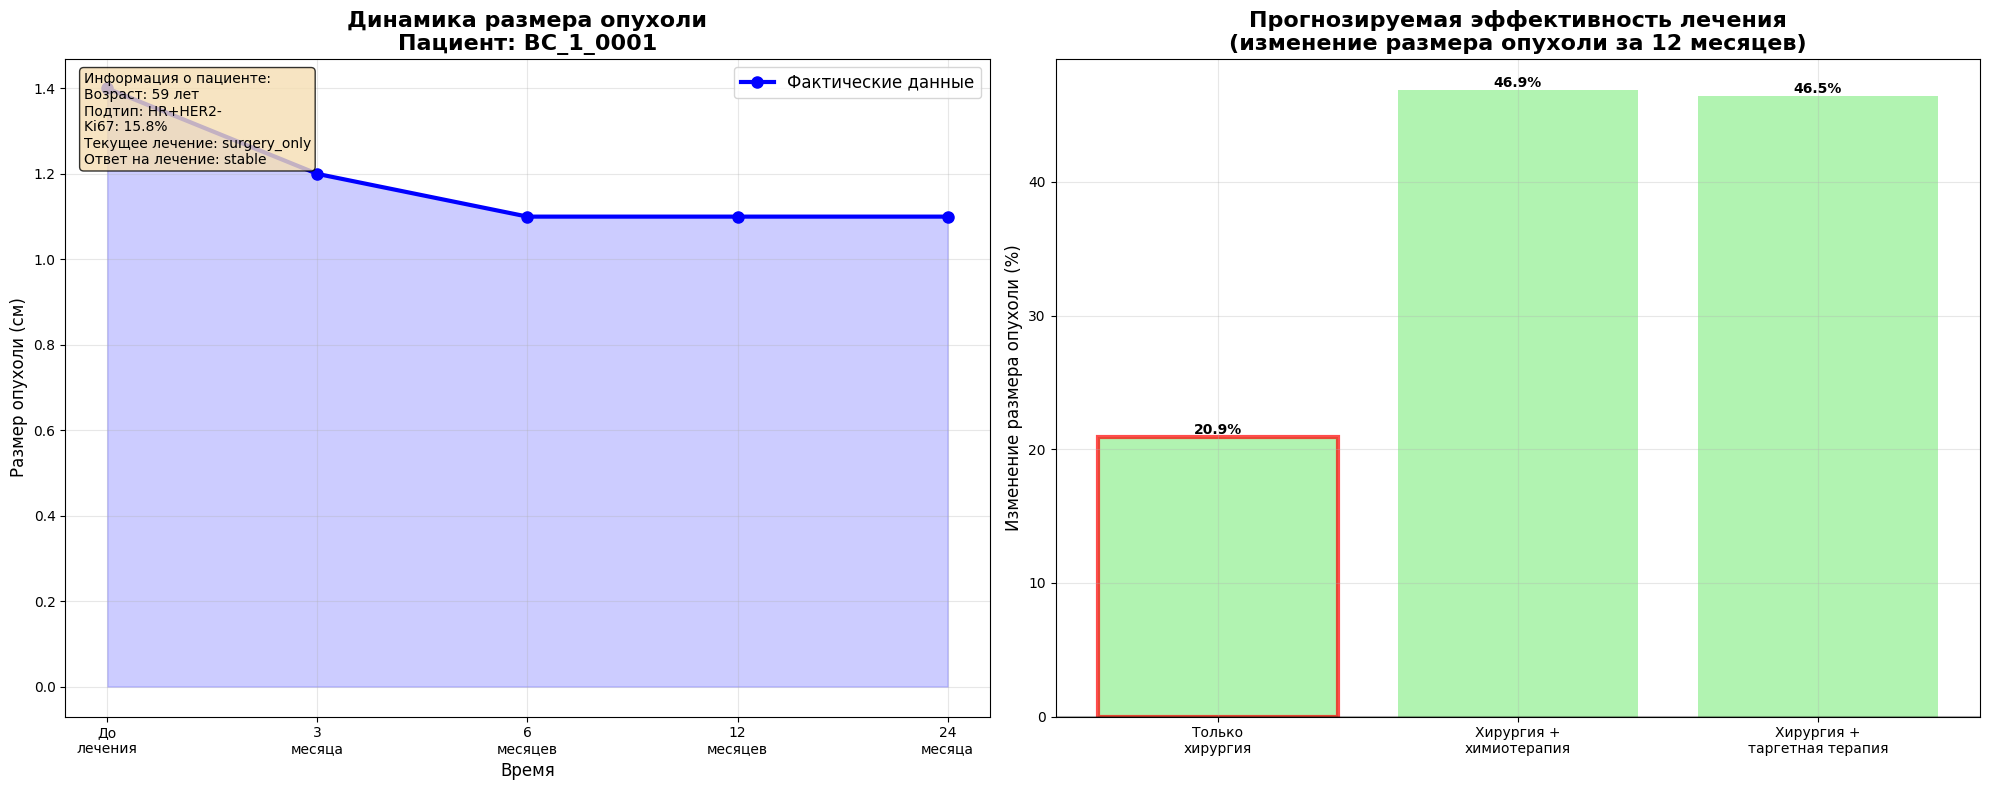


РЕКОМЕНДАЦИИ:
Текущее лечение: surgery_only
Рекомендуемое лечение: surgery_chemo
Ожидаемое уменьшение опухоли: 46.9%
⚠️ Возможное улучшение: +26.0%

АНАЛИЗ ПАЦИЕНТА 2: BC_1_0002


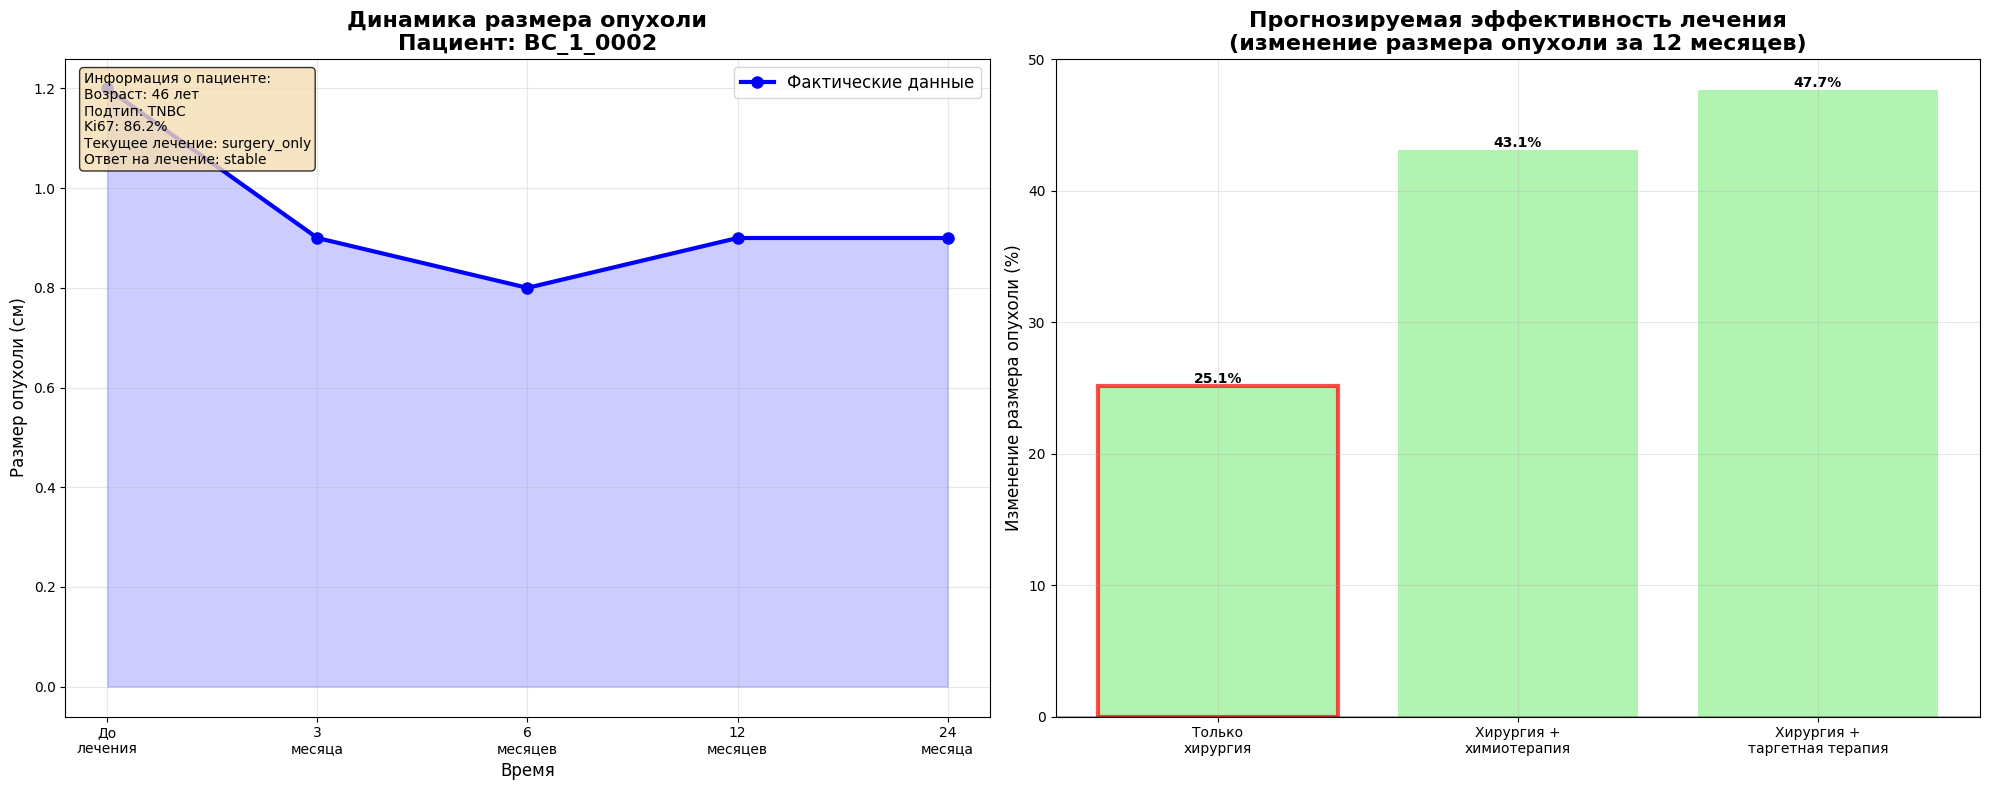


РЕКОМЕНДАЦИИ:
Текущее лечение: surgery_only
Рекомендуемое лечение: surgery_target
Ожидаемое уменьшение опухоли: 47.7%
⚠️ Возможное улучшение: +22.5%

АНАЛИЗ ПАЦИЕНТА 3: BC_1_0003


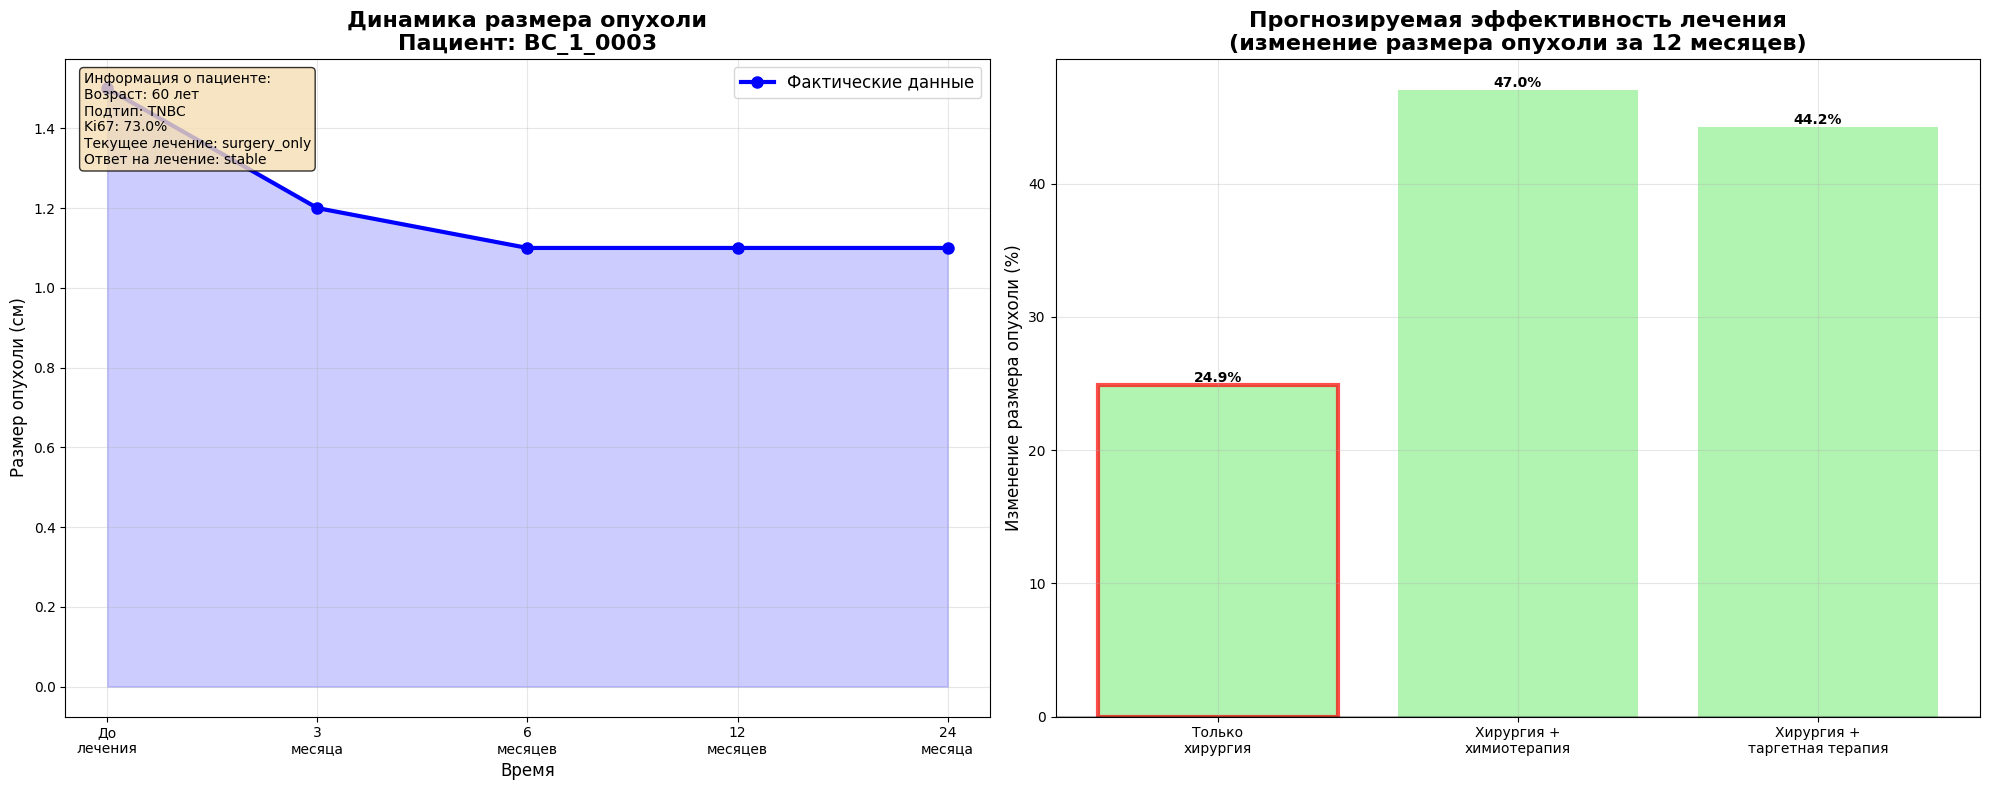


РЕКОМЕНДАЦИИ:
Текущее лечение: surgery_only
Рекомендуемое лечение: surgery_chemo
Ожидаемое уменьшение опухоли: 47.0%
⚠️ Возможное улучшение: +22.2%

АНАЛИЗ ЗАВЕРШЕН


In [ ]:
# Целевой переменная - изменение размера опухоли за 12 месяцев в процентом количестве
df['tumor_change_percentage'] = ((df['tumor_size_before'] - df['tumor_size_12m']) / df['tumor_size_before']) * 100

# Текстовый тип данных кодируем по категориям ---> 0,1,2....
le = LabelEncoder()
categorical_columns = ['gender', 'menopausal_status', 'molecular_subtype', 'er_status',
                      'pr_status', 'her2_status', 'brca_mutation', 'surgery_type',
                      'treatment', 'treatment_response', 'lymph_node_status']

for col in categorical_columns:
    df[col + '_encoded'] = le.fit_transform(df[col].astype(str))

# Гиперпараметры для модели
feature_columns = [
    'age', 'menopausal_status_encoded', 'family_history',
    'molecular_subtype_encoded', 'er_status_encoded', 'pr_status_encoded',
    'her2_status_encoded', 'brca_mutation_encoded', 'ki67_level',
    'treatment_encoded', 'surgery_type_encoded', 'tumor_size_before',
    'performance_status', 'tumor_grade', 'lymph_node_status_encoded',
    'positive_lymph_nodes'
]
# для обучения бережно и ласково копируем датасет чтобы не повредить original DataFrame
X = df[feature_columns].copy()
y = df['tumor_change_percentage']

# Разделение
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучение модели методом RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
#создаем ансамбль из 100 различных деревьев-признаков с сидом 42. Каждое дерево обучается независимо, в последствии все усредняется по веткам.
rf_model.fit(X_train, y_train)

# Оценка модели
y_pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nКачество модели:")
print(f"MSE: {mse:.2f}")
print(f"R²: {r2:.2f}")

# Важность признаков
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)
#rf_model.feature_importances_ - встроенная свойство модели Random Forest

print("\nТоп-5 важных признаков:")
print(feature_importance.head())

# Функция для прогнозирования эффективности лечения
def predict_treatment_effectiveness(patient_id, df, model, feature_columns):
      patient_data = df[df['patient_id'] == patient_id].iloc[0]
      current_features = patient_data[feature_columns].values.reshape(1, -1)

      treatments = ['surgery_only', 'surgery_chemo', 'surgery_target']
      predictions = {}


      treatment_encoder = LabelEncoder()
      treatment_encoder.fit(df['treatment'].unique())

      for treatment in treatments:
          temp_features = current_features.copy()
          treatment_idx = feature_columns.index('treatment_encoded')

          try:
              treatment_encoded = treatment_encoder.transform([treatment])[0]
              temp_features[0, treatment_idx] = treatment_encoded
              predicted_change = model.predict(temp_features)[0]
              predictions[treatment] = predicted_change
          except:
              predictions[treatment] = 0

      return predictions, patient_data

#  визуализация
def plot_patient_tumor_dynamics(patient_id, df, model, feature_columns):
    try:
        patient_data = df[df['patient_id'] == patient_id].iloc[0]

        # Фактические данные
        time_points = ['tumor_size_before', 'tumor_size_3m', 'tumor_size_6m', 'tumor_size_12m', 'tumor_size_24m']
        time_labels = ['До\nлечения', '3\nмесяца', '6\nмесяцев', '12\nмесяцев', '24\nмесяца']
        actual_sizes = [patient_data[col] for col in time_points]
        current_treatment = patient_data['treatment']

        # Прогнозы
        predictions, _ = predict_treatment_effectiveness(patient_id, df, model, feature_columns)


        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

        # График 1: Фактическая динамика
        ax1.plot(time_labels, actual_sizes, 'bo-', linewidth=3, markersize=8, label='Фактические данные')
        ax1.fill_between(time_labels, actual_sizes, alpha=0.2, color='blue')
        ax1.set_title(f'Динамика размера опухоли\nПациент: {patient_id}', fontsize=16, fontweight='bold')
        ax1.set_xlabel('Время', fontsize=12)
        ax1.set_ylabel('Размер опухоли (см)', fontsize=12)
        ax1.grid(True, alpha=0.3)
        ax1.legend(fontsize=12)

        # Информация о пациенте
        patient_info = f"""Информация о пациенте:
Возраст: {patient_data['age']} лет
Подтип: {patient_data['molecular_subtype']}
Ki67: {patient_data['ki67_level']}%
Текущее лечение: {current_treatment}
Ответ на лечение: {patient_data['treatment_response']}"""

        ax1.text(0.02, 0.98, patient_info, transform=ax1.transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8), fontsize=10)

        # График 2: Прогноз эффективности
        treatments = list(predictions.keys())
        effectiveness = list(predictions.values())

        treatment_labels = {
            'surgery_only': 'Только\nхирургия',
            'surgery_chemo': 'Хирургия +\nхимиотерапия',
            'surgery_target': 'Хирургия +\nтаргетная терапия'
        }

        colors = ['lightcoral' if eff < 0 else 'lightgreen' for eff in effectiveness]
        bars = ax2.bar([treatment_labels[t] for t in treatments], effectiveness, color=colors, alpha=0.7)

        for bar, eff in zip(bars, effectiveness):
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height, f'{eff:.1f}%',
                    ha='center', va='bottom' if height >= 0 else 'top', fontweight='bold')

        ax2.set_title('Прогнозируемая эффективность лечения\n(изменение размера опухоли за 12 месяцев)',
                     fontsize=16, fontweight='bold')
        ax2.set_ylabel('Изменение размера опухоли (%)', fontsize=12)
        ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
        ax2.grid(True, alpha=0.3)

        # Выделение текущего лечения
        if current_treatment in treatments:
            current_idx = treatments.index(current_treatment)
            bars[current_idx].set_edgecolor('red')
            bars[current_idx].set_linewidth(3)

        plt.tight_layout()
        plt.show()

        return predictions

    except Exception as e:
        print(f"Ошибка визуализации для {patient_id}: {e}")
        return None



СИСТЕМА ПРОГНОЗИРОВАНИЯ ЭФФЕКТИВНОСТИ ЛЕЧЕНИЯ

АНАЛИЗ ПАЦИЕНТА 1: BC_1_0951


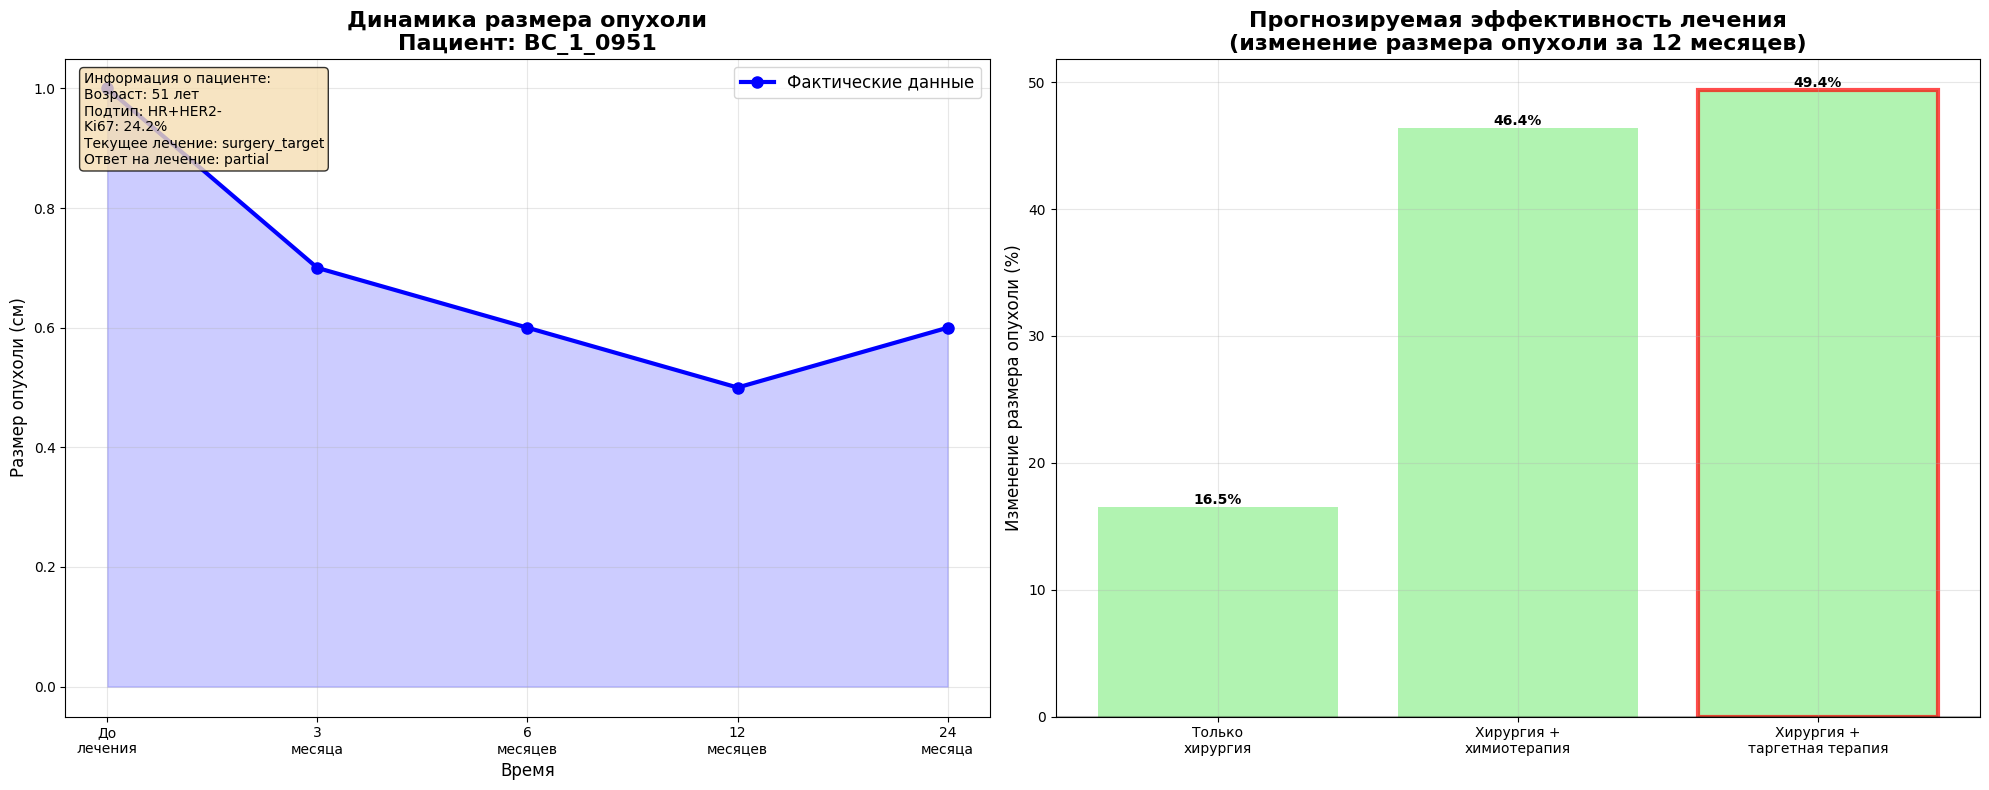


РЕКОМЕНДАЦИИ:
Текущее лечение: surgery_target
Рекомендуемое лечение: surgery_target
Ожидаемое уменьшение опухоли: 49.4%

АНАЛИЗ ПАЦИЕНТА 2: BC_1_0952


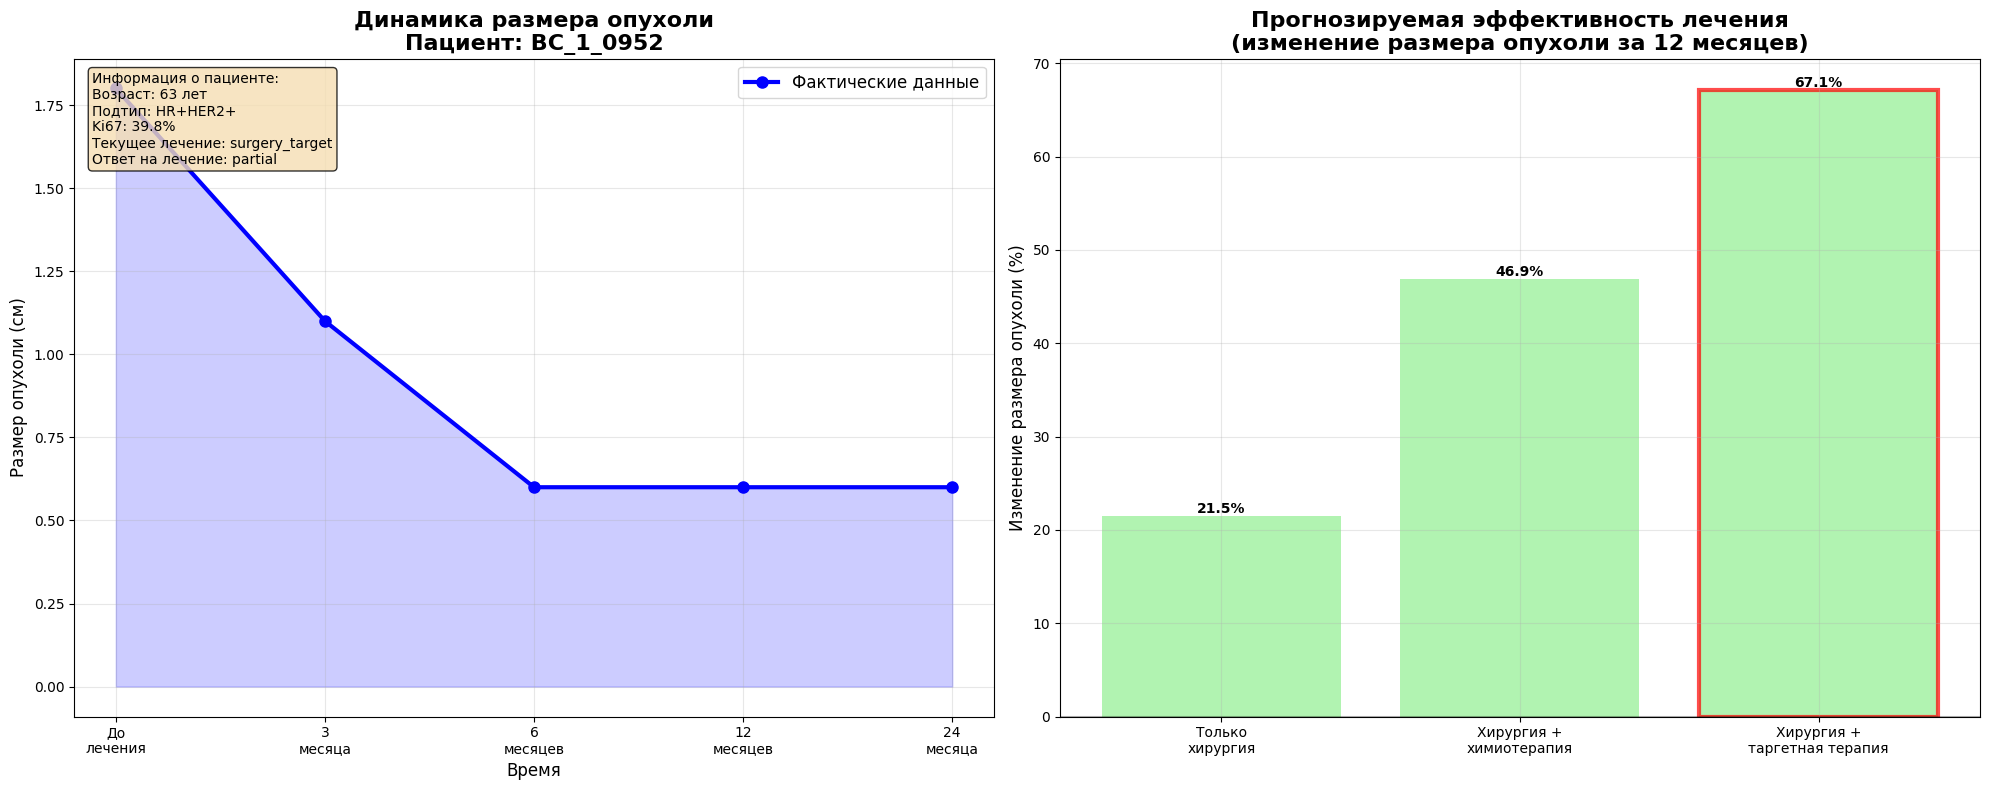


РЕКОМЕНДАЦИИ:
Текущее лечение: surgery_target
Рекомендуемое лечение: surgery_target
Ожидаемое уменьшение опухоли: 67.1%

АНАЛИЗ ПАЦИЕНТА 3: BC_1_0953


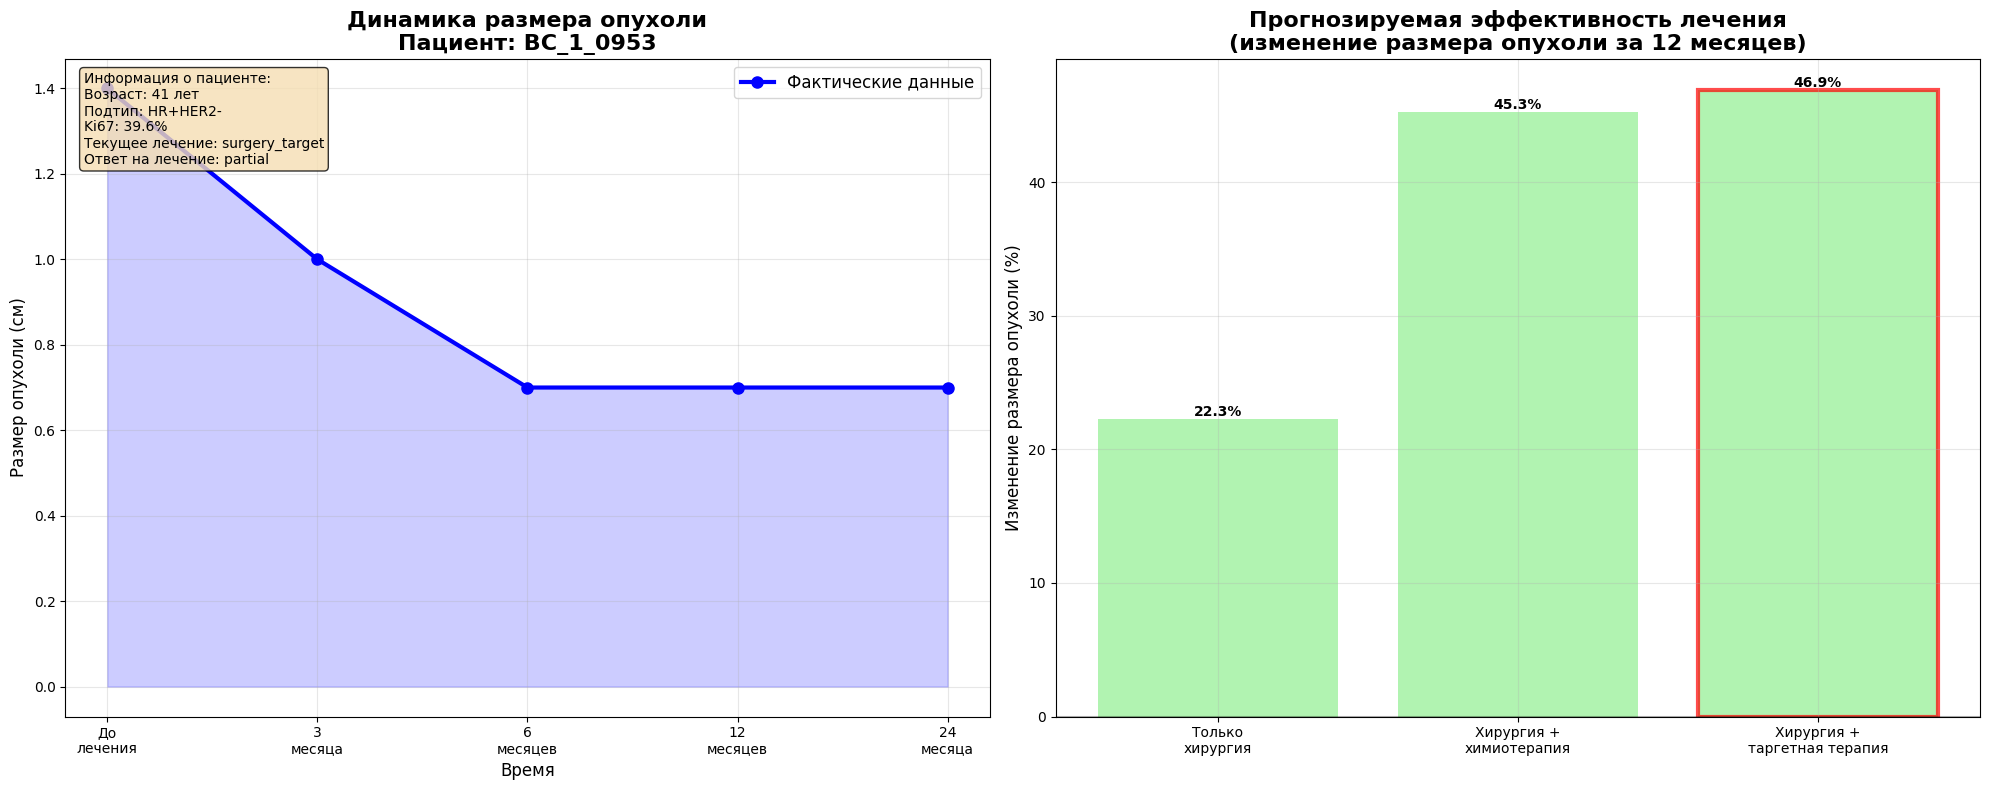


РЕКОМЕНДАЦИИ:
Текущее лечение: surgery_target
Рекомендуемое лечение: surgery_target
Ожидаемое уменьшение опухоли: 46.9%

АНАЛИЗ ЗАВЕРШЕН


In [ ]:
#Представление началось
print("\n" + "="*60)
print("СИСТЕМА ПРОГНОЗИРОВАНИЯ ЭФФЕКТИВНОСТИ ЛЕЧЕНИЯ")
print("="*60)

sample_patients = df['patient_id'].unique()[950:953]

for i, patient_id in enumerate(sample_patients, 1):
    print(f"\n{'='*50}")
    print(f"АНАЛИЗ ПАЦИЕНТА {i}: {patient_id}")
    print(f"{'='*50}")

    predictions = plot_patient_tumor_dynamics(patient_id, df, rf_model, feature_columns)

    if predictions:
        best_treatment = max(predictions, key=predictions.get)
        current_treatment = df[df['patient_id'] == patient_id]['treatment'].iloc[0]
        patient_data = df[df['patient_id'] == patient_id].iloc[0]

        print(f"\nРЕКОМЕНДАЦИИ:")
        print(f"Текущее лечение: {current_treatment}")
        print(f"Рекомендуемое лечение: {best_treatment}")
        print(f"Ожидаемое уменьшение опухоли: {predictions[best_treatment]:.1f}%")

        if current_treatment in predictions:
            improvement = predictions[best_treatment] - predictions[current_treatment]
            if improvement > 5:
                print(f" Возможное улучшение: +{improvement:.1f}%")

print(f"\n{'='*60}")
print("АНАЛИЗ ЗАВЕРШЕН")
print(f"{'='*60}")